In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

In [2]:
folder_task = '/home/xingguang/Documents/ECE661/hw3/hw3_Task1_Images/Images'
path_1 = os.path.join(folder_task, '1.jpeg')
path_2 = os.path.join(folder_task, '2.jpeg')
path_3 = os.path.join(folder_task, '3.jpeg')
outpath_1 = os.path.join(folder_task, 'ptop1.jpeg')
outpath_2 = os.path.join(folder_task, 'ptop2.jpeg')
outpath_3 = os.path.join(folder_task, 'ptop3.jpeg')

img_1 = cv2.cvtColor(cv2.imread(path_1), cv2.COLOR_BGR2RGB)
img_2 = cv2.cvtColor(cv2.imread(path_2), cv2.COLOR_BGR2RGB)
img_3 = cv2.cvtColor(cv2.imread(path_3), cv2.COLOR_BGR2RGB)

In [3]:
def choosePQRS(img=1):
    if img == 1:
        P = [472, 118]
        Q = [449, 562]
        S = [1406, 448]
        R = [1447, 715]
    if img == 2:
        P = [382, 575]
        Q = [379, 834]
        S = [593, 551]
        R = [606, 922]
    if img == 3:
        # P = [686, 744] #1st monitor
        # Q = [736, 2100]
        # S = [1772, 783]
        # R = [1775, 1616]
        P = [2062, 698] #2nd
        Q = [2096, 1479]
        S = [2668, 717]
        R = [2694, 1333]
    return np.asarray([P, Q, S, R])

def definePQRS(width, height):
    P = [0, 0]
    Q = [0, height]
    S = [width, 0]
    R = [width, height]
    return np.asarray([P, Q, S, R])

In [4]:
def findHomoproj(source, target):
    def F_unit(source_point, target_point):
        x, y = source_point[0], source_point[1]
        x_, y_ = target_point[0], target_point[1]
        return np.asarray([[x, y, 1, 0, 0, 0, -x*x_, -y*x_], 
                        [0, 0, 0, x, y, 1, -x*y_, -y*y_]])
    F_list = [F_unit(source[i], target[i]) for i in range(4)]
    F = np.concatenate(F_list, axis=0)
    T_span = target.reshape((-1,1))
    H_param = np.matmul(np.linalg.inv(F), T_span)
    H = np.ones((9, 1))
    H[:8, :] = H_param
    return H.reshape((3, 3))

def newHomography(H, r, width, height):
    expanded = projTransform(np.linalg.inv(H), r)
    l, r = np.amin(expanded[:, 0]), np.amax(expanded[:, 0])
    t, b = np.amin(expanded[:, 1]), np.amax(expanded[:, 1])
    s_1 = (r - l) / width
    s_2 = (b - t) / height
    H_new = np.asarray([[s_1, 0, l], [0, s_2, t], [0, 0, 1]])
    return np.matmul(H, H_new)

In [5]:
def projTransform(H, source):
    nps = source.shape[0]
    source_rep = np.concatenate((source, np.ones((nps,1))), axis=1)
    t_homo = np.matmul(H, source_rep.T).T
    t_norm = t_homo / t_homo[:,2].reshape((nps,1))
    return t_norm[:,:2]

In [6]:
def projRange(source, H):
    out = np.zeros_like(source)
    height, width, _ = source.shape
    for i in range(out.shape[0]):
        for j in range(out.shape[1]):
            coor_source = np.asarray([[j, i]])
            coor_target = projTransform(H, coor_source).squeeze()
            h, w = int(coor_target[1]), int(coor_target[0])
            if 0 <= h < height and 0 <= w <width:
                out[i,j,:] = source[h, w,:]
    return out

In [7]:
range_1 = choosePQRS(1)
range_2 = choosePQRS(2)
range_3 = choosePQRS(3)
range_41 = definePQRS(img_1.shape[1], img_1.shape[0])
range_42 = definePQRS(img_2.shape[1], img_2.shape[0])
range_43 = definePQRS(img_3.shape[1], img_3.shape[0])
H_41 = findHomoproj(range_41, range_1)
H_42 = findHomoproj(range_42, range_2)
H_43 = findHomoproj(range_43, range_3)
H_14 = findHomoproj(range_1, range_41)
H_24 = findHomoproj(range_2, range_42)
H_34 = findHomoproj(range_3, range_43)

H_1 = newHomography(H_41, range_41, img_1.shape[1], img_1.shape[0])
H_2 = newHomography(H_42, range_42, img_2.shape[1], img_2.shape[0])
H_3 = newHomography(H_43, range_43, img_3.shape[1], img_3.shape[0])

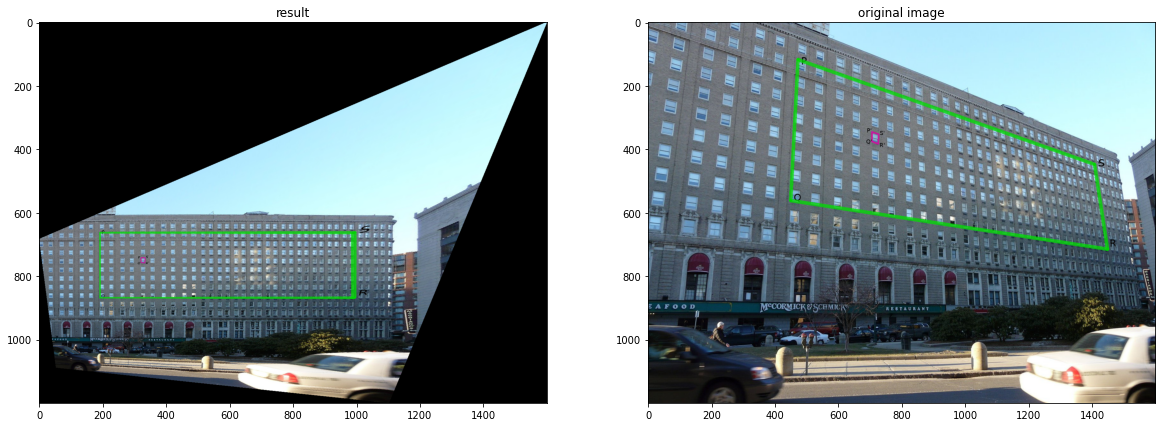

In [8]:
result = projRange(img_1, H_1)
plt.figure(figsize=(20,40))
plt.subplot(121)
plt.title('result')
plt.imshow(result)
plt.subplot(122)
plt.title('original image')
plt.imshow(img_1)

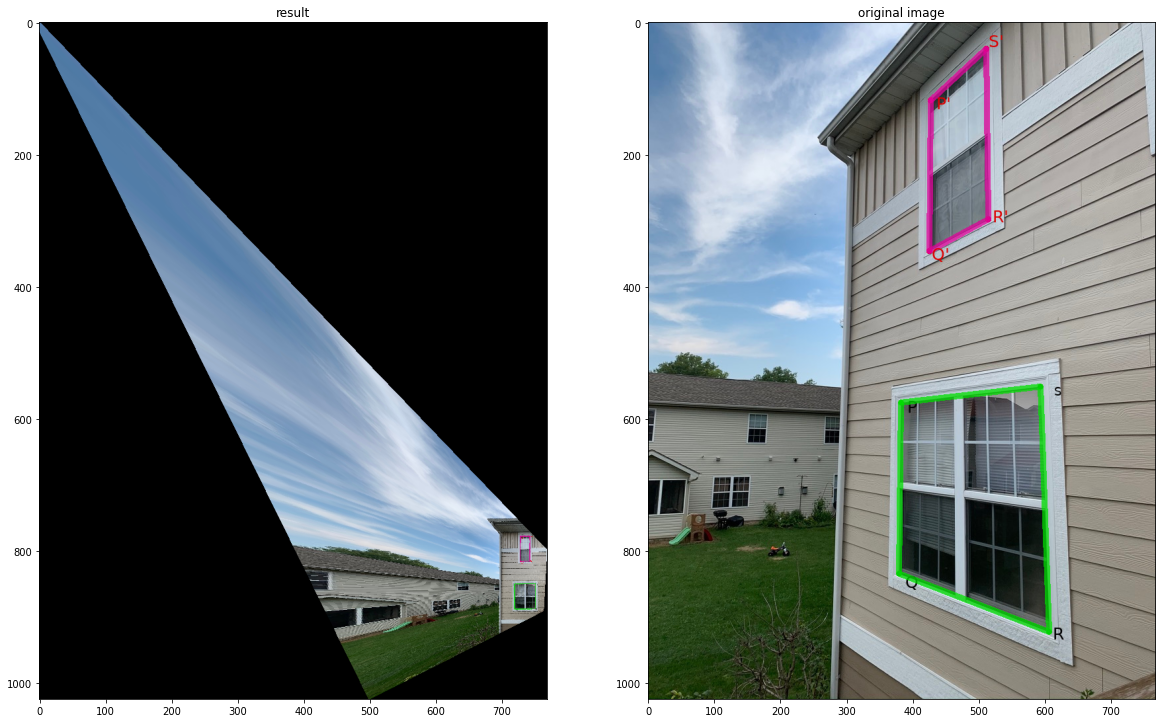

In [9]:
result = projRange(img_2, H_2)
plt.figure(figsize=(20,40))
plt.subplot(121)
plt.title('result')
plt.imshow(result)
plt.subplot(122)
plt.title('original image')
plt.imshow(img_2)

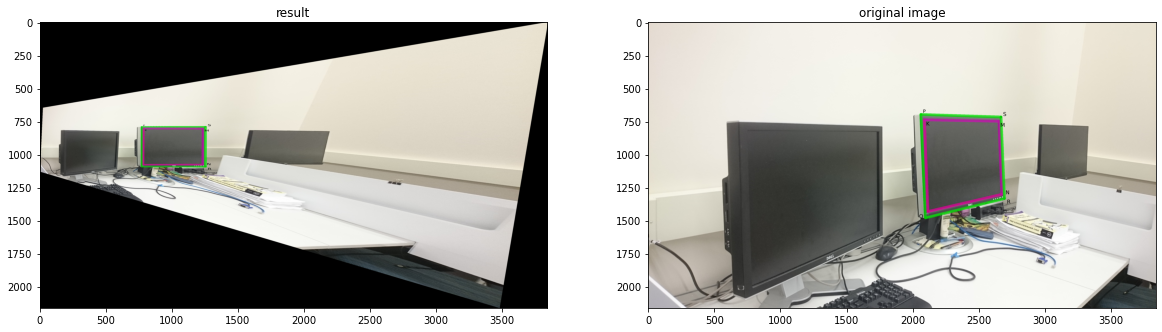

In [10]:
result = projRange(img_3, H_3)
plt.figure(figsize=(20,40))
plt.subplot(121)
plt.title('result')
plt.imshow(result)
plt.subplot(122)
plt.title('original image')
plt.imshow(img_3)

In [11]:
H_12 = findHomoproj(range_2, range_1)
H_23 = findHomoproj(range_3, range_2)
H_13 = np.matmul(H_12, H_23)
print('projective matrix from 2 to 1:', H_12)
print('projective matrix from 3 to 2:', H_23)
print('projective matrix from 3 to 1:', H_13)

projective matrix from 2 to 1: [[-9.18046346e+00  6.49534672e-04  3.19375511e+03]
 [-3.15351348e+00 -1.11238684e+00  1.76606247e+03]
 [-4.43670797e-03  5.58133430e-05  1.00000000e+00]]
projective matrix from 3 to 2: [[-3.21368226e-02 -1.08199377e-02  2.25379900e+02]
 [-1.77880007e-01  1.15784528e-01  5.14106673e+02]
 [-2.87232567e-04 -1.57144830e-05  1.00000000e+00]]
projective matrix from 3 to 1: [[-6.22435091e-01  4.92190386e-02  1.12499710e+03]
 [-2.08055375e-01 -1.22429124e-01  4.83438418e+02]
 [-1.54578948e-04  3.87527424e-05  2.87492118e-02]]


In [12]:
folder_task = '/home/xingguang/Documents/ECE661/hw3/hw3_Task2_Images/Images'
path_1 = os.path.join(folder_task, '1.jpeg')
path_2 = os.path.join(folder_task, '2.jpeg')
path_3 = os.path.join(folder_task, '3.jpeg')
outpath_1 = os.path.join(folder_task, 'ptop1.jpeg')
outpath_2 = os.path.join(folder_task, 'ptop2.jpeg')
outpath_3 = os.path.join(folder_task, 'ptop3.jpeg')

img_1 = cv2.cvtColor(cv2.imread(path_1), cv2.COLOR_BGR2RGB)
img_2 = cv2.cvtColor(cv2.imread(path_2), cv2.COLOR_BGR2RGB)
img_3 = cv2.cvtColor(cv2.imread(path_3), cv2.COLOR_BGR2RGB)

In [13]:
def choosePQRS(img=1):
    if img == 1:
        P = [2101, 493]
        Q = [2075, 1473]
        S = [2637, 652]
        R = [2661, 1556]
    if img == 2:
        P = [1128, 883]
        Q = [945, 2027]
        S = [2180, 1308]
        R = [2129, 2195]
    if img == 3:
        P = [495, 232] 
        Q = [453, 3189]
        S = [2406, 309]
        R = [2263, 3245]
    return np.asarray([P, Q, S, R])

def definePQRS(width, height):
    P = [0, 0]
    Q = [0, height]
    S = [width, 0]
    R = [width, height]
    return np.asarray([P, Q, S, R])

range_1 = choosePQRS(1)
range_2 = choosePQRS(2)
range_3 = choosePQRS(3)
range_41 = definePQRS(img_1.shape[1], img_1.shape[0])
range_42 = definePQRS(img_2.shape[1], img_2.shape[0])
range_43 = definePQRS(img_3.shape[1], img_3.shape[0])
H_41 = findHomoproj(range_41, range_1)
H_42 = findHomoproj(range_42, range_2)
H_43 = findHomoproj(range_43, range_3)
H_14 = findHomoproj(range_1, range_41)
H_24 = findHomoproj(range_2, range_42)
H_34 = findHomoproj(range_3, range_43)

H_1 = newHomography(H_41, range_41, img_1.shape[1], img_1.shape[0])
H_2 = newHomography(H_42, range_42, img_2.shape[1], img_2.shape[0])
H_3 = newHomography(H_43, range_43, img_3.shape[1], img_3.shape[0])

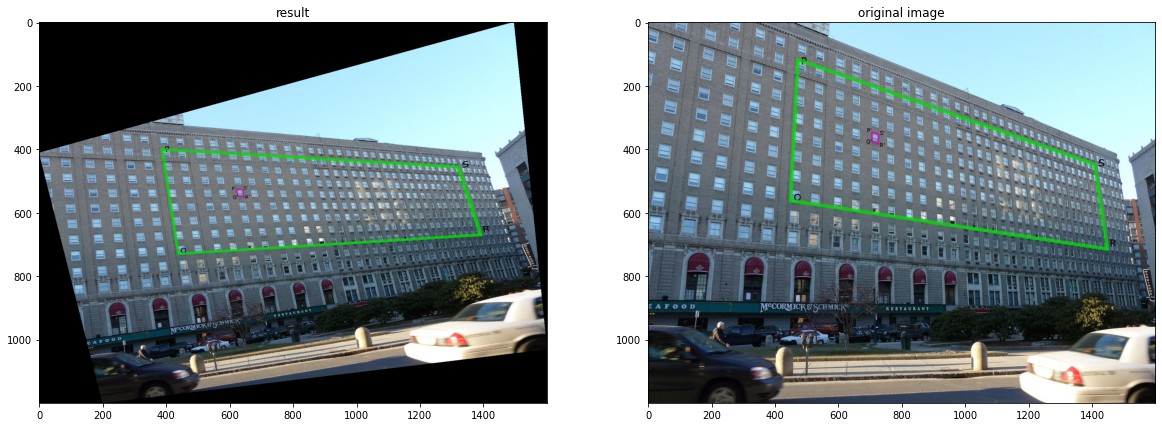

In [14]:
result = projRange(img_1, H_1)
plt.figure(figsize=(20,40))
plt.subplot(121)
plt.title('result')
plt.imshow(result)
plt.subplot(122)
plt.title('original image')
plt.imshow(img_1)

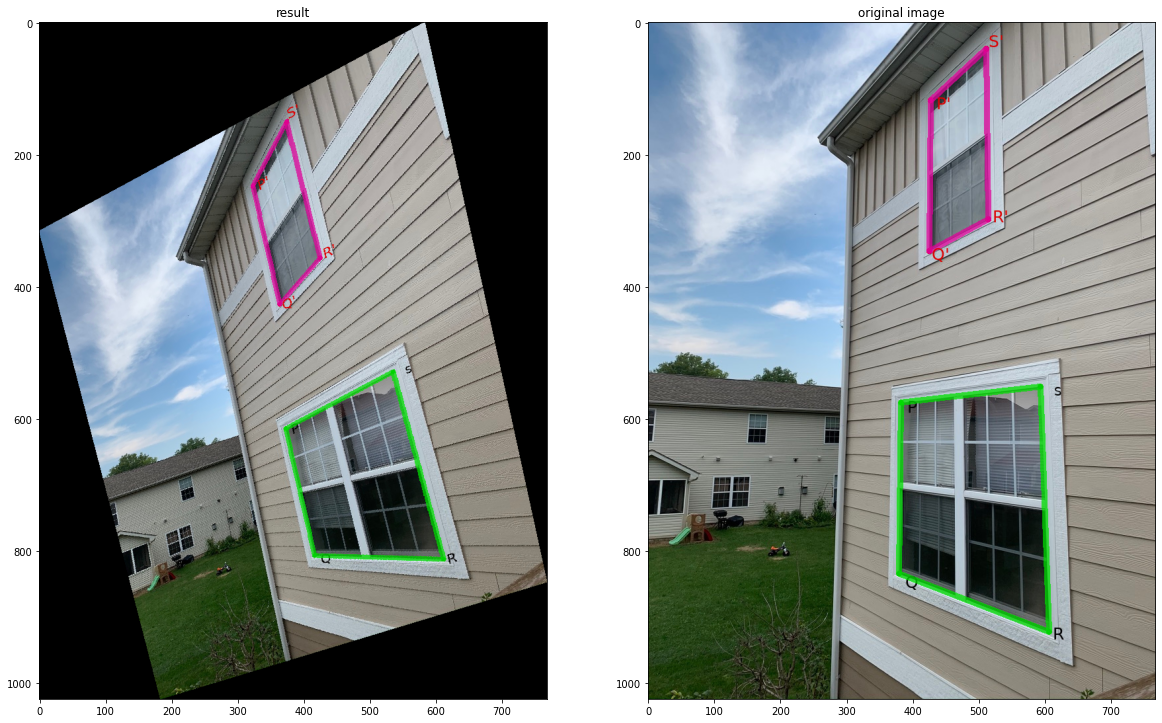

In [15]:
result = projRange(img_2, H_2)
plt.figure(figsize=(20,40))
plt.subplot(121)
plt.title('result')
plt.imshow(result)
plt.subplot(122)
plt.title('original image')
plt.imshow(img_2)

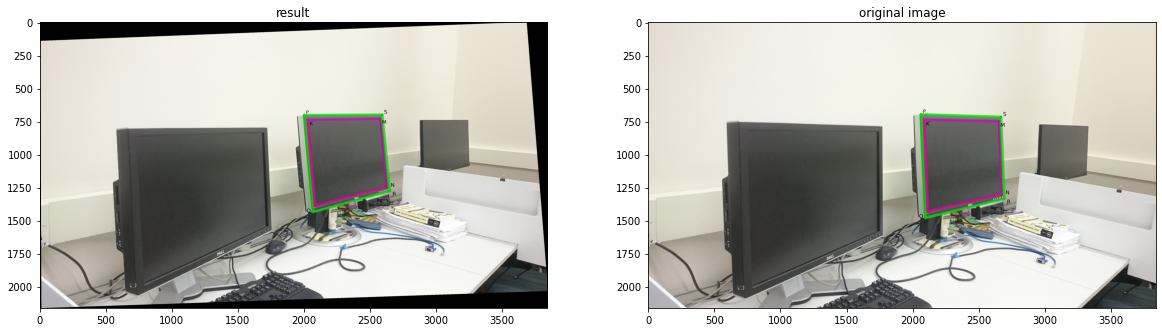

In [16]:
result = projRange(img_3, H_3)
plt.figure(figsize=(20,40))
plt.subplot(121)
plt.title('result')
plt.imshow(result)
plt.subplot(122)
plt.title('original image')
plt.imshow(img_3)